In [23]:
import pandas as pd
import os
import torch
import joblib
import numpy as np

from TransformerModel import TimeSeriesTransformer, grid_search
from torch.utils.data import TensorDataset
from Util import create_sequences, sample_dataset, plot_metric, plot_multiple_curves
from torch.utils.data import random_split

In [24]:
# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
# 准备数据，只需要准备train 和 test，训练模型时会对train做k-fold。
df_train = pd.read_csv ('../TockFormerData\SPY_1hour_train.csv')
X, y, scaler, target_indices = create_sequences (df_train, seq_length=32, target_cols=['open', 'high', 'low', 'close'],
                                                 scale=True)
train_dataset = TensorDataset (X, y)
sample_dataset = sample_dataset (train_dataset, 0.1)

In [26]:
df_test = pd.read_csv ('../TockFormerData\SPY_1hour_test.csv')
X_t, y_t, _, _ = create_sequences (df_test, seq_length=32, target_cols=['open', 'high', 'low', 'close'],
                                   scale=True)
test_dataset = TensorDataset (X_t, y_t)

In [27]:
# 检查数据集大小
print (f"Train dataset size: {len(train_dataset)}")
print (f"Sample dataset size: {len(sample_dataset)}")
print (f"Test dataset size: {len(test_dataset)}")

Train dataset size: 19639
Sample dataset size: 1963
Test dataset size: 231


In [ ]:
# 定义网格搜索，找最好的超参数
# 固定的初始化参数
init_args = {
    'input_dim': 49,
    'output_dim': 4,
    'seq_length': 32,
    'dropout': 0.1
}

# 架构超参数空间
param_grid = {
    'model_dim': [64, 128],
    'num_heads': [2, 4],
    'num_layers': [2, 3]
}

best_params, best_score = grid_search (
    TimeSeriesTransformer,
    init_args,
    train_dataset,
    param_grid,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params)
print ('Best avg CV MSE:', best_score)

In [28]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

best_params = {'model_dim': 64,
 'num_heads': 4,
 'num_layers': 3,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1}

model = TimeSeriesTransformer (**best_params)

best_params

# result = model.cross_validate (train_dataset, k=5, scaler=scaler, target_indices=target_indices)

{'model_dim': 64,
 'num_heads': 4,
 'num_layers': 3,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1}

In [ ]:
print (result)

In [29]:
# 重新整理数据，抽取10% 做validate，剩下的为train

total_len = len (train_dataset)
val_len = int (0.1 * total_len)
train_len = total_len - val_len

# 使用 random_split 划分数据集
train_subset, val_subset = random_split (train_dataset, [train_len, val_len])

In [30]:
# 如果表现优异，对整体进行 train
model = TimeSeriesTransformer (**best_params)
train_loss, mse_list_train, r2_list_train = model.train_model (
    train_subset,
    val_dataset=val_subset,
    num_epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=5,
    log=True,
)

Using device: cuda
Epoch 1: Bad batch threshold reached at batch 148. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 235. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 285. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 383. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 433. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 483. Reshuffling training data.
Epoch 1/50, Train Loss: 190557.187670
Epoch 1/50, Val MSEs: [79469608.0, 35791408.0, 51998400.0, 53166232.0], R²: [-13180.2802734375, -5939.2490234375, -8619.4619140625, -8816.1396484375]
Epoch 2: Bad batch threshold reached at batch 59. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 203. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 253. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 362. Reshuffling training data.
Epoch 2: Bad b

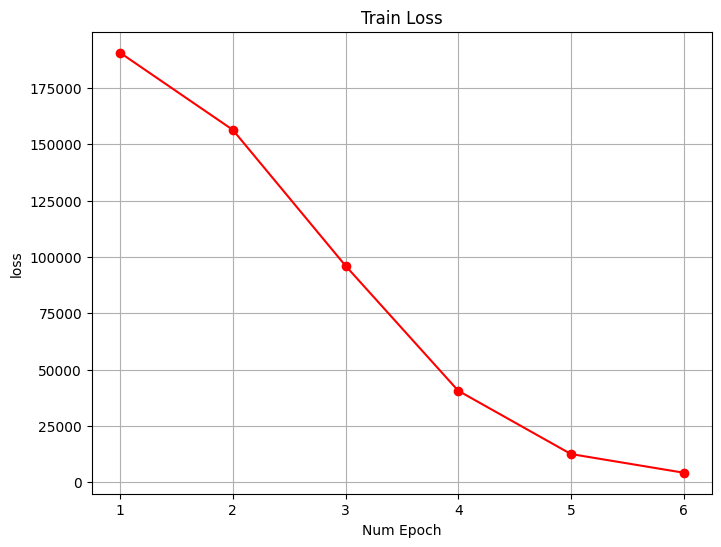

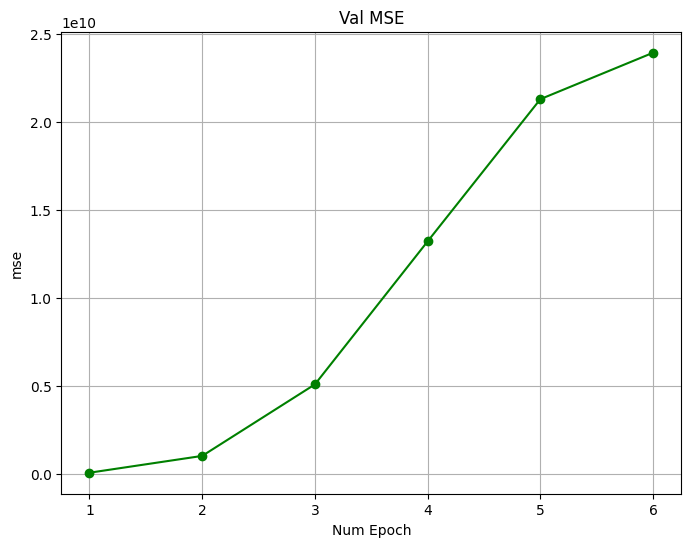

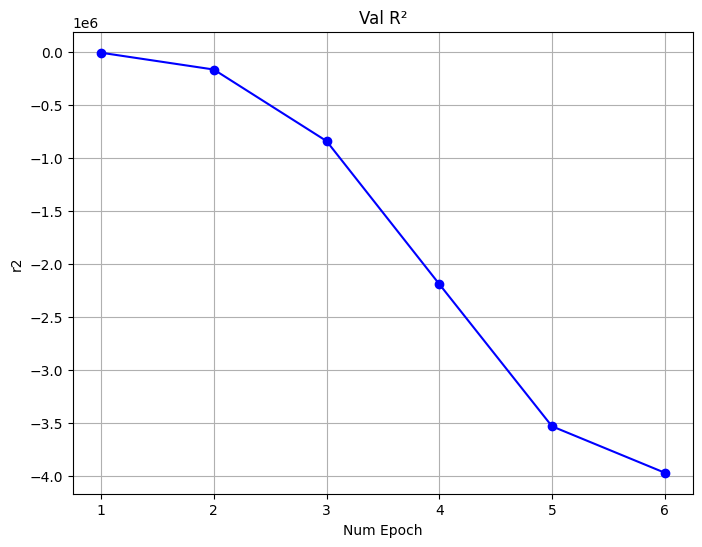

In [31]:
# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

In [32]:
# 对test 进行测试
mse_list_test, r2_list_test, preds_test, targets = model.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)

In [33]:
print (preds_test)
# print (targets)

[[9351.515  6422.1504 7650.23   7729.611 ]
 [9351.522  6422.4595 7649.921  7729.4307]
 [9351.2    6422.398  7650.0547 7729.459 ]
 [9350.862  6421.7764 7650.3545 7729.9194]
 [9351.648  6422.566  7649.957  7728.993 ]
 [9351.164  6422.073  7650.018  7729.3887]
 [9351.663  6422.7275 7649.9854 7728.384 ]
 [9351.226  6423.064  7649.3096 7728.14  ]
 [9351.169  6423.7856 7648.97   7727.516 ]
 [9350.751  6422.8643 7648.9883 7728.105 ]
 [9351.352  6421.3604 7648.6333 7727.1123]
 [9350.581  6421.8413 7649.8325 7727.93  ]
 [9351.924  6423.1123 7648.646  7728.375 ]
 [9351.724  6422.545  7649.0728 7728.809 ]
 [9352.036  6422.2188 7649.3105 7728.9023]
 [9351.994  6422.064  7649.62   7728.993 ]
 [9352.036  6421.9165 7649.714  7729.2354]
 [9352.14   6422.1226 7649.7837 7729.249 ]
 [9352.019  6422.1406 7649.882  7729.359 ]
 [9351.8    6422.132  7649.848  7729.3564]
 [9351.572  6422.283  7649.8735 7729.656 ]
 [9352.023  6422.696  7649.639  7729.246 ]
 [9352.046  6422.2456 7649.701  7729.753 ]
 [9351.994 

测试集 MSE:  [77230248.0, 34310472.0, 50215676.0, 51347204.0]
测试集 R²:  [-1796528.5, -846410.25, -1089112.875, -1190718.5]


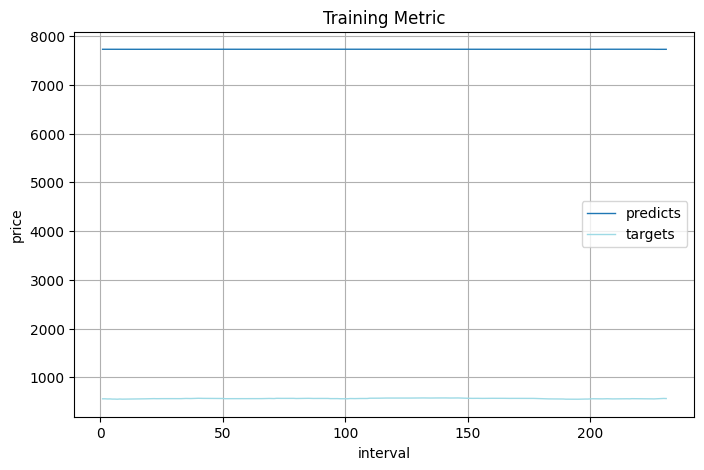

In [34]:
print ("测试集 MSE: ", mse_list_test)
print ("测试集 R²: ", r2_list_test)

curve_dict = {}
curve_dict['predicts'] = preds_test[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 如果test表现优异，则保存
model_out = "./xxx/xxx/"
scaler_out = "./xxx/xxx/"

os.makedirs (os.path.dirname (model_out), exist_ok=True)
os.makedirs (os.path.dirname (scaler_out), exist_ok=True)

print ("=" * 10 + " 保存模型Essentials... " + "=" * 10)
torch.save (model.state_dict (), model_out)
joblib.dump (scaler, scaler_out)